In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from luminol.anomaly_detector import AnomalyDetector
from luminol.modules.time_series import TimeSeries

In [17]:
START_PERIOD = '2019-06-01'
FREQUENCY = 'D'
PERIOD_COUNT = 30

In [18]:
%matplotlib inline

In [19]:
def get_time_series(event_name):
    events = pd.read_csv(f"./datasets/mindset_{event_name}.csv")
    event_timestamps = pd.DataFrame(events, columns=['timestamp'])
    
    df = (pd.to_datetime(event_timestamps['timestamp'])
       .dt.floor(FREQUENCY)
       .value_counts()
       .rename_axis('date')
       .reset_index(name='count')
       .sort_values('date'))
    
    all_timestamps = pd.date_range(START_PERIOD, periods=PERIOD_COUNT, freq=FREQUENCY)
    all_timestamps = pd.DataFrame(all_timestamps)
    all_timestamps.columns = ['date']
    
    time_series = pd.merge(all_timestamps, df, left_on='date', right_on='date', how='left')
    time_series.fillna(value = 0, inplace = True)
    
    return time_series

def get_anomalies(times_series):
    d = {}
    for index, row in times_series.iterrows():
        unix_epoch = int(row['date'].timestamp())
        d[unix_epoch] = row['count']
        
    detector = AnomalyDetector(d)
    return detector.get_anomalies()

def anomaly_values(time_series, anomalies):
    values = []
    
    for index, row in time_series.iterrows():
        cur_date = row['date']

        is_anomaly = 0
        for anomaly in anomalies:
            anom_start = pd.to_datetime(anomaly.start_timestamp, unit='s')
            anom_end = pd.to_datetime(anomaly.end_timestamp, unit='s')
            if cur_date >= anom_start and cur_date <= anom_end:
                is_anomaly = anomaly.anomaly_score
                break

        values.append(is_anomaly)
    
    return values

def plot_graph(time_series, anomalies, event_name):
    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    df = pd.to_numeric(time_series['count'], errors='coerce')
    ax = df.plot()
    ax.title.set_text(event_name)

    anom_vmin = 0
    anom_vmax = 10

    discrete_colors = [(255, 255, 255), (252, 229, 229), (249, 204, 204), (247, 179, 179), (244, 154, 154), (242, 129, 129), (239, 103, 103), (236, 78, 78), (234, 53, 53), (231, 28, 28), (229, 3, 0)]
    discrete_colors = [(r/255., g/255., b/255.) for r, g, b in discrete_colors]         
    colormap = ListedColormap(discrete_colors)

    Z = np.array([anomaly_values(time_series, anomalies)])
    ax.pcolor(Z, cmap=colormap, vmin=anom_vmin, vmax=anom_vmax)

/anaconda3/envs/lazylantern/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (22,26,29,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/anaconda3/envs/lazylantern/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (23,27,30,41) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


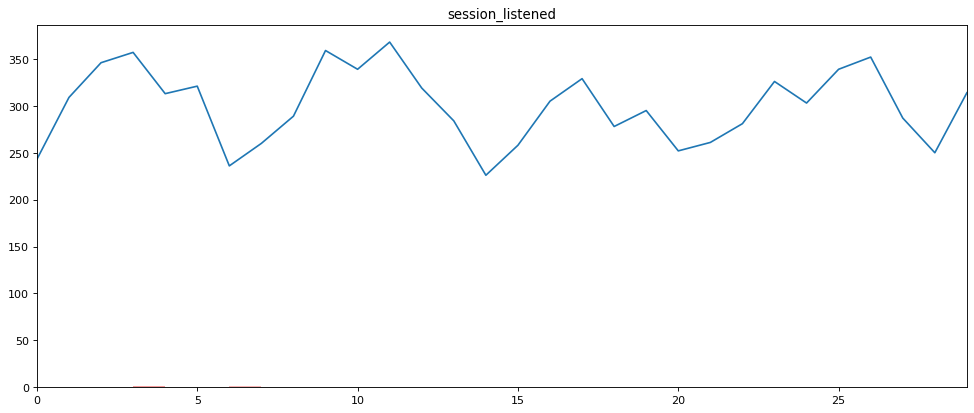

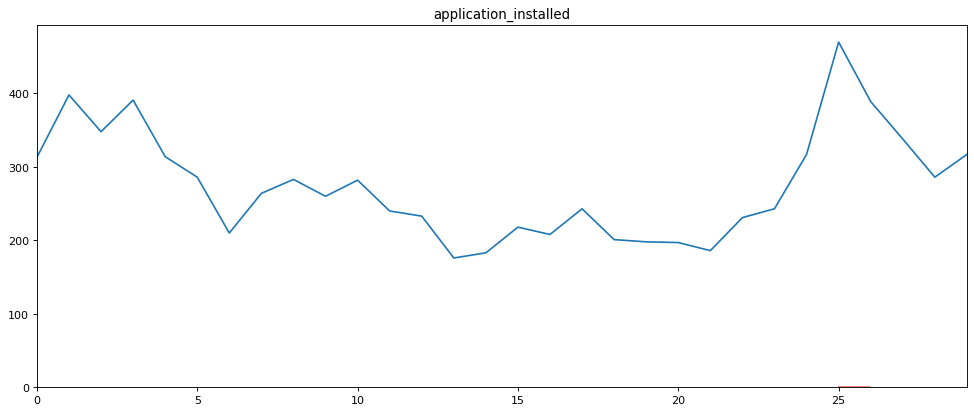

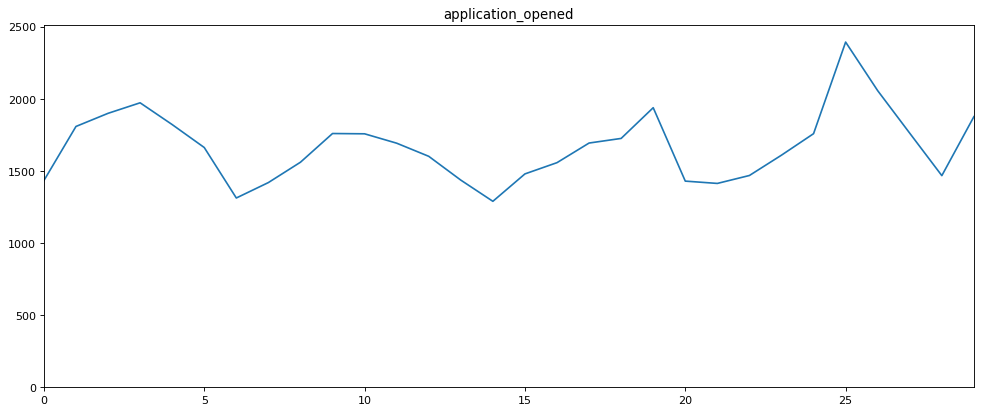

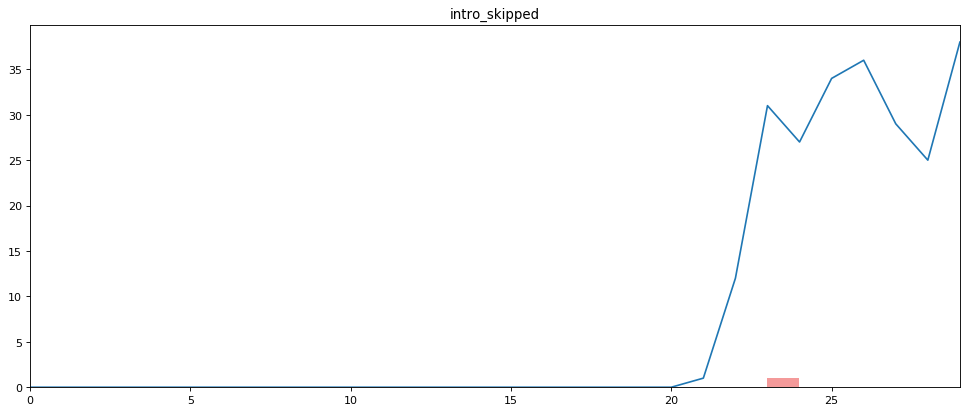

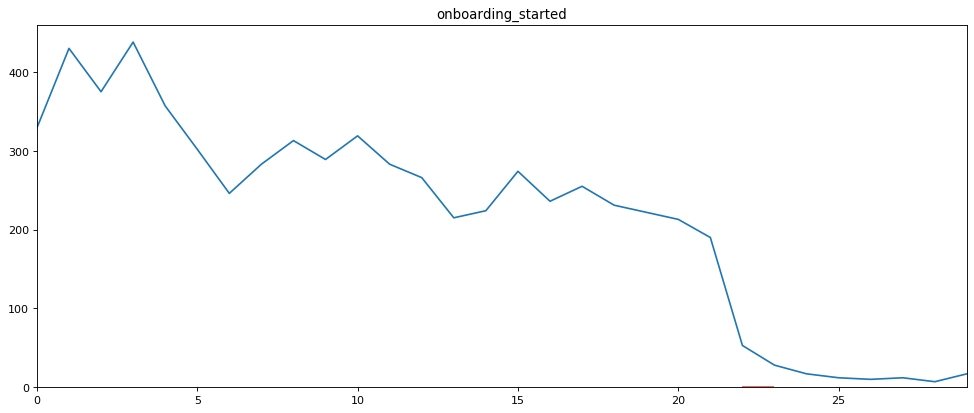

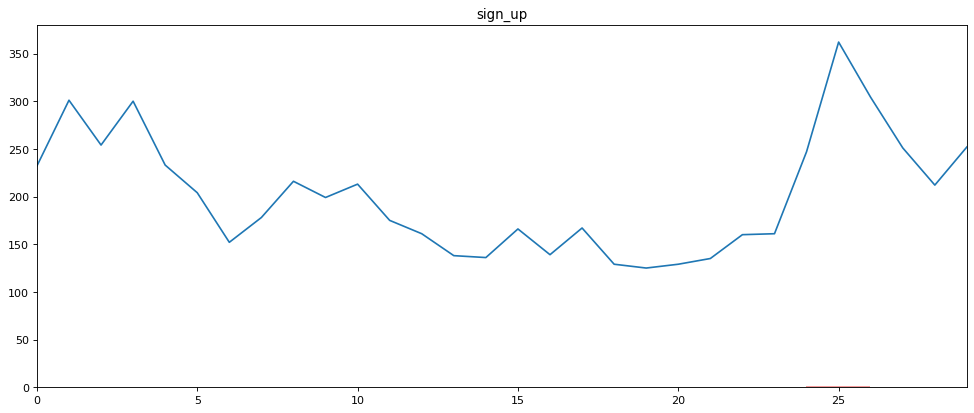

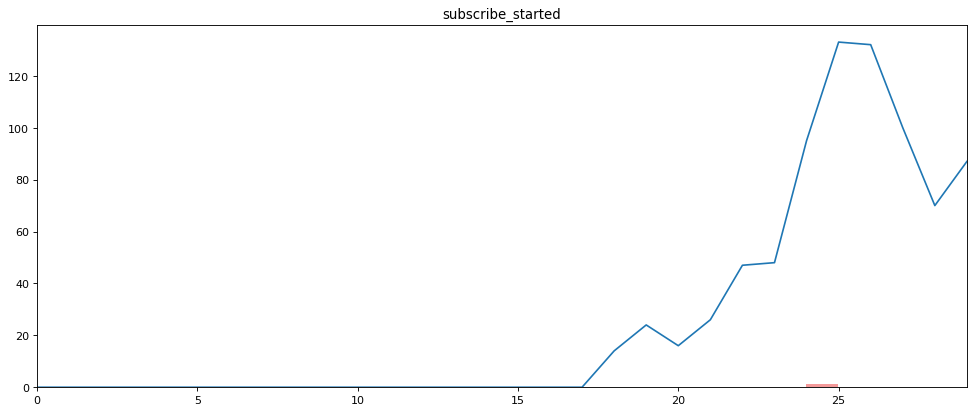

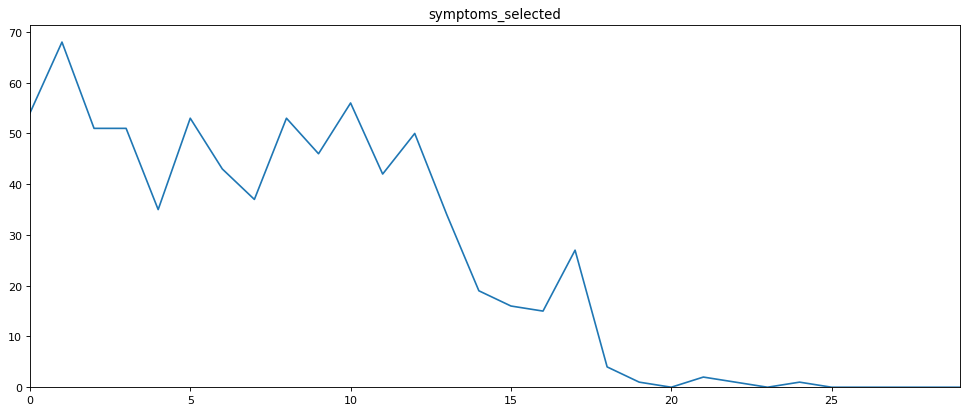

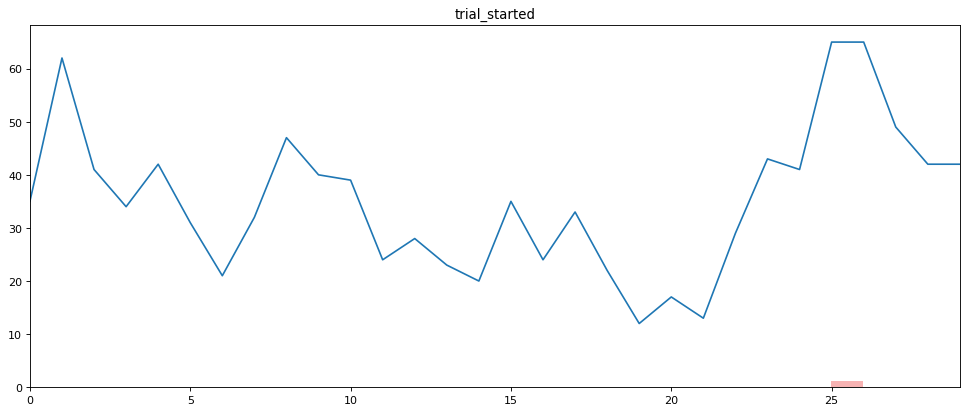

In [20]:
event_names = ["session_listened", "application_installed", "application_opened", "intro_skipped", "onboarding_started", "sign_up", "subscribe_started", "symptoms_selected", "trial_started"]
# event_names = ["session_listened"]
for event_name in event_names:
    time_series = get_time_series(event_name)
    anomalies = get_anomalies(time_series)
    plot_graph(time_series, anomalies, event_name)